# Word2Vec model development

## Imports

In [ ]:
# Preprocessing
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import spacy
from spacy.lang.en.examples import sentences

# Data wrangling & timing
import pandas as pd
from time import time
from collections import defaultdict

# Word2Vec
import multiprocessing
from gensim.models.word2vec import Word2Vec
from gensim.models.phrases import Phrases, Phraser

# Loggings to monitor Word2vec modeling
import logging
logging.basicConfig(format='%(levelname)s - %(asctime)s: %(message)s', datefmt= '%H:%M:%S', level=logging.INFO)

# Timing
from tqdm import tqdm

# Visualisation
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import pickle

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/shared-libs/python3.7/py/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO - 10:49:23: generated new fontManager


## Preprocessing

In [ ]:
with open('../Data/tweet_df_attempt3.p', 'rb') as f: 
    data = pickle.load(f)
    
len(data)

9829

In [ ]:
s_tweets = data['full_text'].drop_duplicates() # remove duplicates
s_tweets = s_tweets[~s_tweets.str.contains('RT')] # remove retweets

len(s_tweets)

6598

In [ ]:
# Define RegEx patterns for cleaning
twitter_pattern = r'@[a-zA-Z0-9_]{1,16}'                 # Remove twitter handles
retweet_pattern = r'RT'                                  # Remove retweet indicators
short_URL_pattern = r'https:\/\/t\.co\/[a-zA-Z0-9\-\.]+' # Remove shortened "https://t.co/..." Twitter URLs
other_URL_pattern = r'https:\/\/[A-z0-9?\.\/-_=!]+'      # Remove other URLs

In [ ]:
pattern_list = [
    twitter_pattern,
    retweet_pattern,
    short_URL_pattern,
    other_URL_pattern
    ]

In [ ]:
# Apply patterns
for pattern in pattern_list:
    s_tweets = s_tweets.str.replace(pattern, '', regex = True)

In [ ]:
# Set up English SpaCy pipeline for preprocessing
nlp = spacy.load(
    'en_core_web_sm',
    disable = ['ner', 'parser'] # disabling Named Entity Recognition for speed
)

def cleaning(doc):
    '''
    Lemmatizes and removes stopwords.
    Doc needs to be a spacy Doc object
    '''
    
    txt = [token.lemma_ for token in doc if not token.is_stop]
    
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [ ]:
# Remove non-alphabetic characters
brief_cleaning = (re.sub("[^A-Za-z]+", ' ', str(tweet)).lower() for tweet in s_tweets)

In [ ]:
# Apply cleaning pipeline
t = time()

txt = [cleaning(doc) for doc in tqdm(nlp.pipe(brief_cleaning, batch_size = 3000))]

print('\nTime to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

6598it [00:24, 273.92it/s]
Time to clean up everything: 0.4 mins



In [ ]:
tokenised_tweets = [str(tweet).split() for tweet in txt if pd.notna(tweet)]

In [ ]:
phrases = Phrases(tokenised_tweets, min_count=30, progress_per = 10000)

INFO - 10:49:49: collecting all words and their counts
INFO - 10:49:49: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 10:49:50: collected 76631 token types (unigram + bigrams) from a corpus of 122342 words and 6598 sentences
INFO - 10:49:50: merged Phrases<76631 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 10:49:50: Phrases lifecycle event {'msg': 'built Phrases<76631 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 0.29s', 'datetime': '2022-05-19T10:49:50.240737', 'gensim': '4.2.0', 'python': '3.7.12 (default, Oct 12 2021, 03:36:26) \n[GCC 8.3.0]', 'platform': 'Linux-5.4.95-42.163.amzn2.x86_64-x86_64-with-debian-10.11', 'event': 'created'}


In [ ]:
bigram = Phraser(phrases)

INFO - 10:49:50: exporting phrases from Phrases<76631 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>
INFO - 10:49:50: FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<38 phrases, min_count=30, threshold=10.0> from Phrases<76631 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000> in 0.28s', 'datetime': '2022-05-19T10:49:50.547728', 'gensim': '4.2.0', 'python': '3.7.12 (default, Oct 12 2021, 03:36:26) \n[GCC 8.3.0]', 'platform': 'Linux-5.4.95-42.163.amzn2.x86_64-x86_64-with-debian-10.11', 'event': 'created'}


In [ ]:
sentences = bigram[tokenised_tweets]

## Word frequency

In [ ]:
word_freq = defaultdict(int)

for sent in sentences:
    
    for i in sent:
        word_freq[i] += 1
        
len(word_freq)

9907

In [ ]:
sorted(word_freq, key=word_freq.get, reverse=True)[:25]

['nuclear',
 'eu',
 'energy',
 'europe',
 's',
 'gas',
 'amp',
 'european',
 'power',
 'taxonomy',
 'green',
 'new',
 'include',
 'eutaxonomy',
 'need',
 'electricity',
 'country',
 'reactor',
 'climate',
 'germany',
 'sustainable',
 'say',
 'uranium',
 'support',
 'plan']

## Embedding

In [ ]:
# Count number of cores in machine
cores = multiprocessing.cpu_count()

In [ ]:
vec_size = 100  # usually 300 is standard, but that yields very large cosine distances 
                # for pretty much all words in this small dataset

nuclear2vec = Word2Vec(
    seed = 123,
    min_count = 5,
    window = 2,
    vector_size = vec_size,
    sample = 0, 
    alpha = 0.03, 
    min_alpha = 0.0007,
    negative = 0,
    epochs = 10,
    workers = cores
)

INFO - 12:30:26: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=100, alpha=0.03>', 'datetime': '2022-05-19T12:30:26.276736', 'gensim': '4.2.0', 'python': '3.7.12 (default, Oct 12 2021, 03:36:26) \n[GCC 8.3.0]', 'platform': 'Linux-5.4.95-42.163.amzn2.x86_64-x86_64-with-debian-10.11', 'event': 'created'}


In [ ]:
t = time()

nuclear2vec.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 12:30:28: collecting all words and their counts
INFO - 12:30:28: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 12:30:28: collected 9907 word types from a corpus of 118943 raw words and 6598 sentences
INFO - 12:30:28: Creating a fresh vocabulary
INFO - 12:30:28: Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 2655 unique words (26.80% of original 9907, drops 7252)', 'datetime': '2022-05-19T12:30:28.437592', 'gensim': '4.2.0', 'python': '3.7.12 (default, Oct 12 2021, 03:36:26) \n[GCC 8.3.0]', 'platform': 'Linux-5.4.95-42.163.amzn2.x86_64-x86_64-with-debian-10.11', 'event': 'prepare_vocab'}
INFO - 12:30:28: Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 107725 word corpus (90.57% of original 118943, drops 11218)', 'datetime': '2022-05-19T12:30:28.438741', 'gensim': '4.2.0', 'python': '3.7.12 (default, Oct 12 2021, 03:36:26) \n[GCC 8.3.0]', 'platform': 'Linux-5.4.95-42.163.amzn2.x86_64-x86_64-with-debian-10.11', 'event': 'pr

In [ ]:
nuclear2vec_terms = { 
    'environment': {
        'eugreendeal',
        'green_investment',
        'sustainable_investment'
        },
    'eu': {
        'nuclearpower',
        'energytransition',
        'decarbonisation'
        },
    'sustainable': {
        'sustainable_finance',
        'sustainablefinance',
        'radiation',
        'netzero'
        },
    'nuclearpower': {
        'renewables'
        },
    'taxonomy': {
        'stopfakegreen',
        'meps',
        'mairead'
        },
    'lobby': {
        'sustainablefinanceeu',
        'leyen',
        'chairman'
        },
    'europeancommission': {
        'radioactive_waste',
        'nuclear_waste'
        },
    'ukrainerussiawar': {
        'geopolitical',
        'russia'
        },
    'nuclearindustry': {
        'netzeroneedsnuclear',
        'iaeagc'
        },
    'rethinknuclear': {
        'waste',
        'research_reactor'
        }
    }

In [ ]:
nuclear2vec.wv.most_similar(positive = ['rethinknuclear'], topn = 25)

[('waste', 0.33525562286376953),
 ('wecare', 0.31258425116539),
 ('process', 0.30842894315719604),
 ('wise', 0.28286173939704895),
 ('compliance', 0.2806806266307831),
 ('apparently', 0.2783953845500946),
 ('research_reactor', 0.27712151408195496),
 ('bind', 0.275431364774704),
 ('picture', 0.26533403992652893),
 ('crazy', 0.2638372480869293),
 ('economy', 0.26132094860076904),
 ('behalf', 0.26102545857429504),
 ('right', 0.2606754004955292),
 ('appreciate', 0.25803977251052856),
 ('finish', 0.2562810778617859),
 ('chart', 0.255765438079834),
 ('convention', 0.2500273585319519),
 ('medium', 0.24663077294826508),
 ('directive', 0.24628479778766632),
 ('conclude', 0.24444551765918732),
 ('korea', 0.24390695989131927),
 ('discharge', 0.23508155345916748),
 ('fossilfuel', 0.23314382135868073),
 ('dedicated', 0.23105821013450623),
 ('del', 0.22933493554592133)]

In [ ]:
nuclear2vec_terms

{'environment': {'eugreendeal', 'green_investment', 'sustainable_investment'},
 'eu': {'decarbonisation', 'energytransition', 'nuclearpower'},
 'sustainable': {'netzero',
  'radiation',
  'sustainable_finance',
  'sustainablefinance'},
 'nuclearpower': {'renewables'},
 'taxonomy': {'mairead', 'meps', 'stopfakegreen'},
 'lobby': {'chairman', 'leyen', 'sustainablefinanceeu'},
 'europeancommission': {'nuclear_waste', 'radioactive_waste'},
 'ukrainerussiawar': {'geopolitical', 'russia'},
 'nuclearindustry': {'iaeagc', 'netzeroneedsnuclear'},
 'rethinknuclear': {'research_reactor', 'waste'}}

In [ ]:
pickle.dump(nuclear2vec_terms, open('nuclear2vec_terms.p', 'wb'))

In [ ]:
# Most frequent model vocab
nuclear2vec.wv.index_to_key[:25]

['nuclear',
 'eu',
 'energy',
 'europe',
 's',
 'gas',
 'amp',
 'european',
 'power',
 'taxonomy',
 'green',
 'include',
 'new',
 'eutaxonomy',
 'need',
 'electricity',
 'country',
 'reactor',
 'climate',
 'germany',
 'sustainable',
 'say',
 'uranium',
 'support',
 'plan']

In [ ]:
def tsnescatterplot(model, word, list_names, PCA_components, top_n = 10):
    '''
    Plot in seaborn the results from the t-SNE dimensionality
    reduction algorithm of the vectors of a query word, its
    list of most similar words, and a list of words.
    '''
    arrays = np.empty((0, vec_size), dtype = 'f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word], topn = top_n)
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from x to 50 dimensions with PCA
    reduc = PCA(n_components = PCA_components).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(
        n_components = 2,
        random_state = 0,
        perplexity = 15,
        early_exaggeration = 10,
        square_distances = True
        ).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({
        'x': [x for x in Y[:, 0]],
        'y': [y for y in Y[:, 1]],
        'words': word_labels,
        'color': color_list
        })
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(
        data = df,
        x = 'x',
        y = 'y',
        fit_reg = False,
        marker = 'o',
        scatter_kws = {
            's': 40,
            'facecolors': df['color']
            }
        )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(
             df['x'][line],
             df['y'][line],
             '  ' + df['words'][line],
             horizontalalignment = 'left',
             verticalalignment = 'bottom',
             size = 'medium',
             color = df['color'][line],
             weight = 'normal'
             ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for "{}"'.format(word))

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


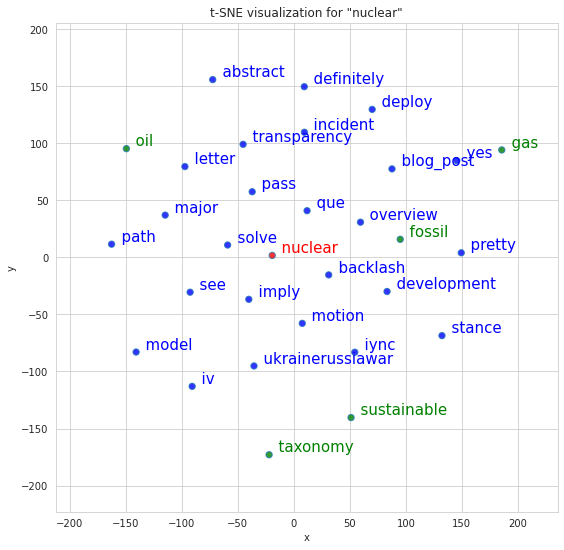

In [ ]:
tsnescatterplot(
    nuclear2vec,
    'nuclear', ['gas', 'taxonomy', 'fossil', 'oil', 'sustainable'],
    PCA_components = 25,
    top_n = 25
    )

In [ ]:
nuclear2vec.wv.doesnt_match(['germany', 'france', 'ukraine', 'russia'])

'france'

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


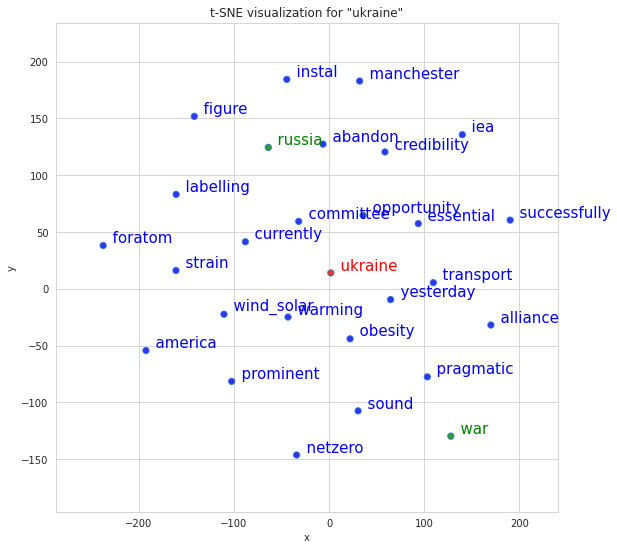

In [ ]:
tsnescatterplot(
    nuclear2vec,
    'ukraine', ['russia', 'war'],
    PCA_components = 25,
    top_n = 25
    )

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


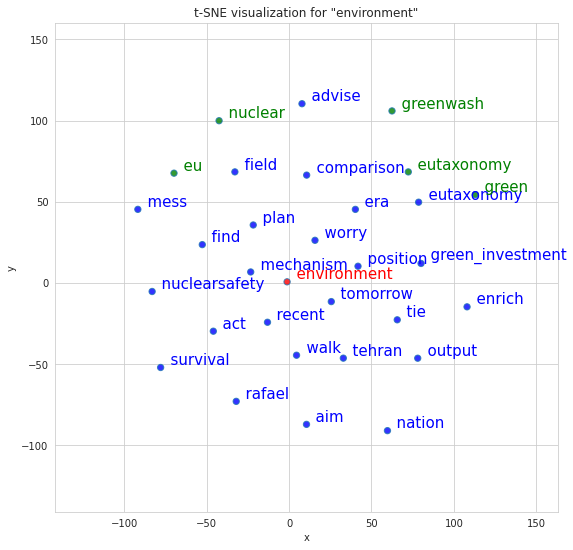

In [ ]:
tsnescatterplot(nuclear2vec, 'environment', ['eu', 'green', 'eutaxonomy', 'greenwash', 'nuclear'], PCA_components = 30, top_n = 25)

In [ ]:
nuclear2vec_terms['environment']

{'eugreendeal', 'green_investment', 'sustainable_investment'}

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=83a05b10-68f2-47cd-90b2-acf816447dd2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>